In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential

import keras_tuner as kt

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [9]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  []


Getting the data from the dataset fetch_20newsgroups.

To this project, was used just 10 of the 20 categories, more than that could take much longer to train the algorithms



### Importing data

In [10]:
categories = [
 'comp.graphics',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'talk.politics.misc',
 'talk.religion.misc']

In [11]:
train_data = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42
)
train_y = train_data.target

test_data = fetch_20newsgroups(
    subset='test', 
    categories=categories, 
    shuffle=True, 
    random_state=42
)
test_y = test_data.target

print(f"There are {len(train_data.data)} news for training")
print(f"There are {len(test_data.data)} news for testing")

There are 5578 news for training
There are 3714 news for testing


The data is in it's raw form, to don't input too much desnecessary data, it need to be cleaned.

So, remove some features of the news, such as the from and some not alphabetical chars

### Cleaning data

In [6]:
def adjust_data(data):
    """
    function to run in each string of the data set and apply the cleaning 
    
    Args:
        temp (string): variable to hold the values on each string while cleaning the dataset

    Returns:
        data (list of string) - lists containing the data cleaned
    """
    
    for i in range(len(data)):
        temp = data[i]
        temp = temp.split('\n')
        #removing the 'from' headline
        temp  = temp[1:]

        #removing empty indexes
        temp = [x for x in temp if x != '']

        #removing not alphabetical chars
        temp = [re.sub(r'/^[\w&.\-]+$/',' ',i) for i in temp]
    
        data[i] = ' '.join(temp)
    
    return data

Using the cleaning function and separating the data.

In [7]:
train_x = adjust_data(train_data.data)
test_x = adjust_data(test_data.data)

In [8]:
#train_y = train_y.reshape(train_y.shape[0],1)
#test_y  = test_y.reshape(test_y.shape[0],1)

### Creating validation split

In [9]:
def train_val_split(News, labels):
    """
    Splits the dataset into training and validation sets
    split in 80% to training and 20% to validation
    
    Args:
        News (list of string): lower-cased News
        labels (list of string): list of labels
    
    Returns:
        train_x, val_x, train_y, val_y - lists containing the data splits
    """
    
    
    # Compute the number of News that will be used for training (should be an integer)
    training_size = int(len(News)*0.8)

    # Split the News and labels into train/validation splits
    train_x = News[0:training_size]
    train_y = labels[0:training_size]

    val_x = News[training_size:]
    val_y = labels[training_size:]
    
    return train_x, val_x, train_y, val_y

In [10]:
train_x, val_x, train_y, val_y = train_val_split(train_x, train_y)

### Tokenazing and padding data

To input the data in the algorithm it's needed to change the vacabulary data to a numeric data, so, keras tokenizer can help with that

after the tokenization, it's necessary a padding to every new have the same len.

In [11]:
token_dict =  {
    'NUM_WORDS': 1000,
    'PADDING' : 'post',
    'OOV_TOKEN' : '<OOV>'
    }

In [12]:
tokenizer = Tokenizer(num_words=token_dict['NUM_WORDS'], 
                        oov_token=token_dict['OOV_TOKEN'])

tokenizer.fit_on_texts(train_x)

word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")

Vocabulary contains 56190 words



To facilitate the process to pad the train, test and val, it's handful to create a function to return the padded dataset

In [13]:
def padding(sentences, tokenizer):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """    
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=150,
                                    padding='post')
    
    return padded_sequences

In [14]:
train_padded = padding(train_x, tokenizer)
val_padded   = padding(val_x, tokenizer)
test_padded  = padding(test_x, tokenizer)

# Modelling

## Baseline model : Logistic Regression

To start de moddeling process, to measure how well a model can do in the dataset, one way is to use a model baseline, that is, a simple model just to know how well it will perform

So, it was implemented a LR model, without changing any parameter



In [15]:
train_padded.shape

(4462, 150)

In [16]:
print(train_y)

[6 0 1 ... 7 0 3]


In [17]:
lr_clf = LogisticRegression()
lr_clf.fit(train_padded, train_y)

lr_pred = lr_clf.predict(train_padded)
train_score = accuracy_score(train_y, lr_pred) * 100
print(f"Train accuracy score: {train_score:.2f}%")

lr_pred = lr_clf.predict(test_padded)
test_score = accuracy_score(test_y, lr_pred) * 100
print(f"Test accuracy score: {test_score:.2f}%")

Train accuracy score: 26.20%
Test accuracy score: 14.08%


## Deep learning I - Convolutional Neural Network

as it's known, CNN can be used in text data to, as it structure is good to recognize patterns in data, being image ou any other type

### Training and tunning

In [27]:
def create_model(hp):
    """
    Creates a text classifier model

    Returns:
        model (tf.keras Model): the text classifier model
    """

    hp_activation = hp.Choice('Activation',values=['relu','tanh'])
    hp_filter     = hp.Int('filter',min_value=32,max_value=512,step=32)
    hp_kernel     = hp.Choice('kernel',values=[3,5,9])
    hp_layer_1    = hp.Int('units',min_value=16,max_value=128,step=16)

    tf.random.set_seed(42)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(1000,32, input_length = 150),
        tf.keras.layers.Conv1D(filters=hp_filter, kernel_size=hp_kernel, activation=hp_activation),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),'accuracy']) 
    
    model.summary()

    ### END CODE HERE

    return model

In [37]:
tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     directory='models',
                     project_name = 'cnn_model'
                     )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

INFO:tensorflow:Reloading Tuner from models/cnn_model/tuner0.json


INFO:tensorflow:Reloading Tuner from models/cnn_model/tuner0.json


In [29]:
tuner.search(train_padded, train_y, 
            epochs=30, validation_data=(val_padded, val_y),
            callbacks=[early_stop])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 18s]
val_accuracy: 0.6774193644523621

Best val_accuracy So Far: 0.7195340394973755
Total elapsed time: 00h 07m 40s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.hypermodel.build(best_hps)

history_I = model.fit(train_padded, train_y, 
                    epochs=30, validation_data=(val_padded, val_y),
                    callbacks=[early_stop])

model.save('./saved_models/cnn_model')

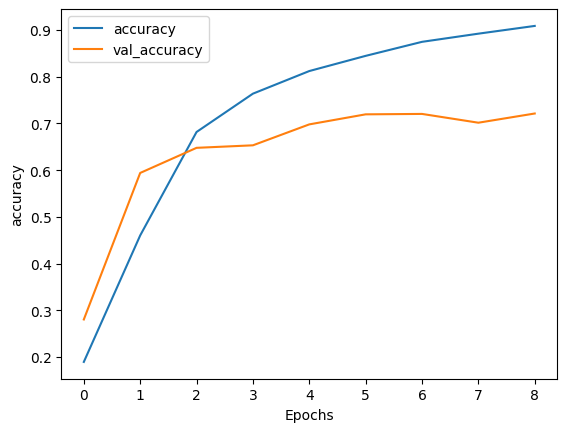

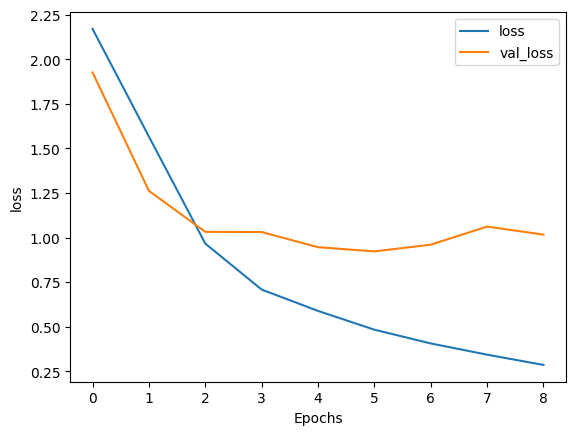

In [40]:
def plot_graphs(history_I, metric):
    plt.plot(history_I.history[metric])
    plt.plot(history_I.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_I, "accuracy")
plot_graphs(history_I, "loss")

### Loading saved model

In [41]:
model_cnn = tf.keras.models.load_model('./saved_models/cnn_model')

### Model Evaluation and testing

In [53]:
cnn_pred = model_cnn.predict(test_padded)
cnn_pred = np.argmax(cnn_pred,axis=1)

117/117 [==============================] - 1s 11ms/step


In [52]:
np.argmax(cnn_pred,axis=1)

array([3, 3, 9, ..., 3, 0, 5])

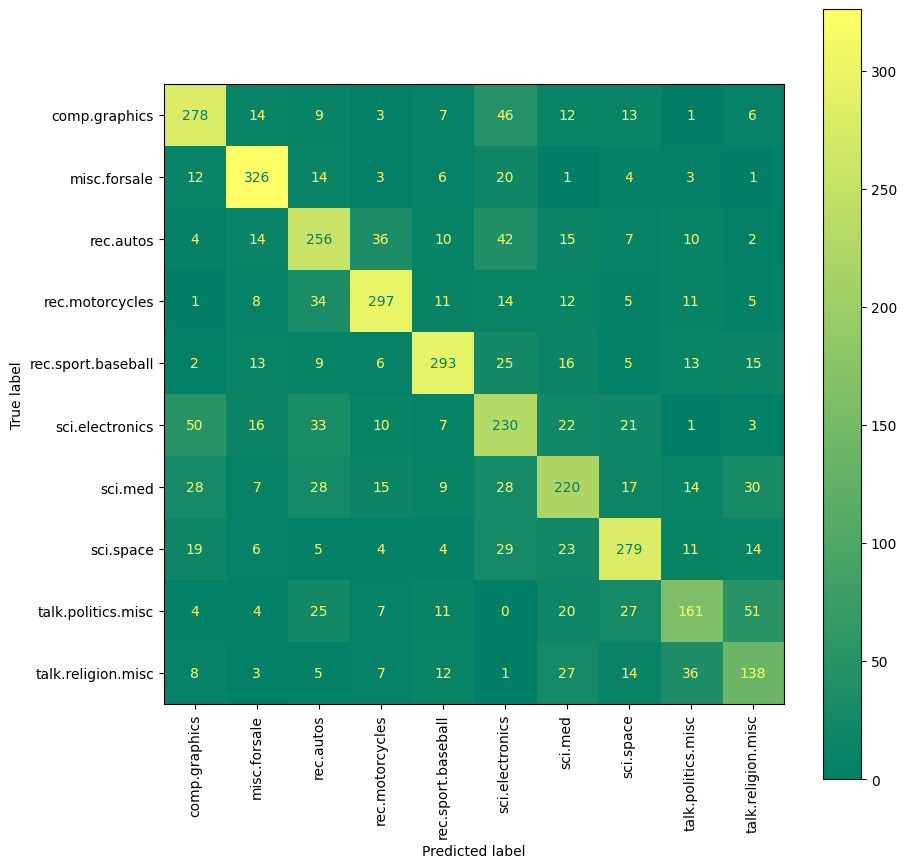

In [55]:
cm = confusion_matrix(test_y, cnn_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels= train_data.target_names
)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

In [57]:
pd.DataFrame(classification_report(test_y, cnn_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.684729,0.714653,0.699371,389.000000
1,0.793187,0.835897,0.813983,390.000000
2,0.612440,0.646465,0.628993,396.000000
3,0.765464,0.746231,0.755725,398.000000
4,0.791892,0.738035,0.764016,397.000000
5,0.528736,0.585242,0.555556,393.000000
6,0.597826,0.555556,0.575916,396.000000
7,0.711735,0.708122,0.709924,394.000000
8,0.616858,0.519355,0.563923,310.000000
9,0.520755,0.549801,0.534884,251.000000


## Deep learning II - Recurrent Neural Network
To compare, it was tested another model using LSTM, a widely known algorithm to text data

In [99]:
def create_model():
    """
    Creates a text classifier model

    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(42)
    
    model = Sequential()

    model.add(Embedding(1000,16, input_length = 150))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 
    
    model.summary()


    return model

In [100]:
model = create_model()

history_II = model.fit(train_padded, train_y, 
                    epochs=30, validation_data=(val_padded, val_y))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 16)           16000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              26800     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 40)                4040      
                                                                 
 dense_19 (Dense)            (None, 10)                410       
                                                                 
Total params: 47,250
Trainable params: 47,250
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
140/140 [==============================] - 5s 17ms/step - loss: 2.2727 - accuracy: 0.1376 - val_loss: 2.2

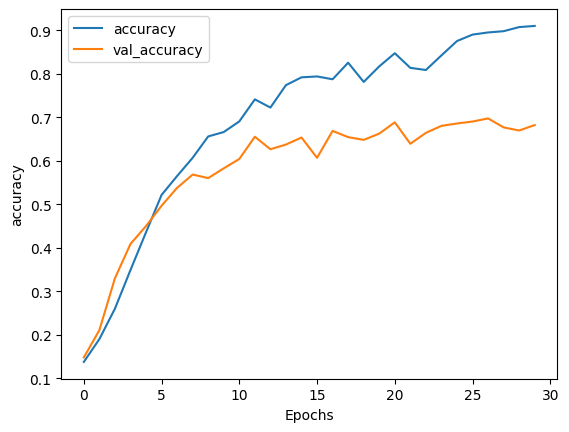

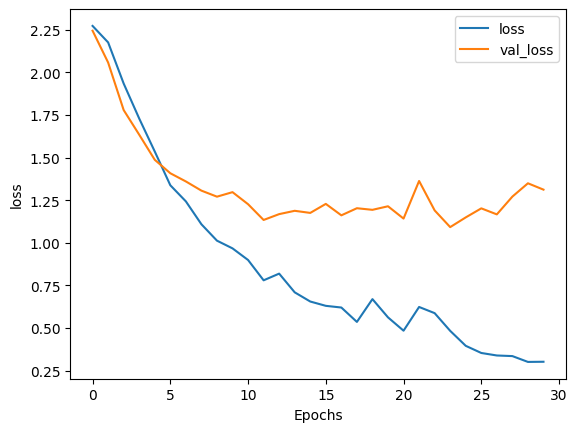

In [101]:
def plot_graphs(history_II, metric):
    plt.plot(history_II.history[metric])
    plt.plot(history_II.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_II, "accuracy")
plot_graphs(history_II, "loss")